SVM on the Sonar Dataset

In [121]:
import matplotlib.pyplot as plt
## Importing required libraries
import numpy as np
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
import pandas as pd
df = pd.read_csv('sonar.csv', header=None)
x_unscaled = df.sample(frac=1, replace=True, random_state=1)
y = x_unscaled[60]
x_unscaled.drop([60],axis=1, inplace=True)
x_unscaled.describe()


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.030244,0.040169,0.045399,0.054121,0.070841,0.104084,0.123117,0.131975,0.176059,0.208460,...,0.017114,0.013970,0.011185,0.011196,0.009503,0.008500,0.007424,0.007587,0.007659,0.006959
std,0.024354,0.034306,0.039356,0.048682,0.052852,0.057876,0.061085,0.085380,0.123304,0.139147,...,0.013203,0.009745,0.007272,0.007579,0.006757,0.005628,0.005706,0.005785,0.006538,0.006221
min,0.001500,0.000600,0.001500,0.005800,0.007600,0.011600,0.013000,0.005500,0.007500,0.024200,...,0.001500,0.000800,0.001500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000200,0.000600
25%,0.013100,0.014600,0.017950,0.022900,0.035100,0.062900,0.087350,0.077700,0.094700,0.109700,...,0.007900,0.007175,0.005500,0.005500,0.004275,0.004600,0.003200,0.003275,0.003600,0.002900
50%,0.022850,0.031800,0.034650,0.039900,0.060800,0.093200,0.105600,0.109900,0.146500,0.180250,...,0.014450,0.011900,0.009600,0.009300,0.007800,0.007300,0.005400,0.006150,0.005800,0.005150
75%,0.040825,0.056300,0.060850,0.068800,0.088300,0.126175,0.149625,0.169050,0.229375,0.259700,...,0.021600,0.017300,0.014900,0.014500,0.012700,0.011475,0.010500,0.010900,0.008900,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.307000,0.332200,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.037600,0.032600,0.031600,0.037700,0.036400,0.043900


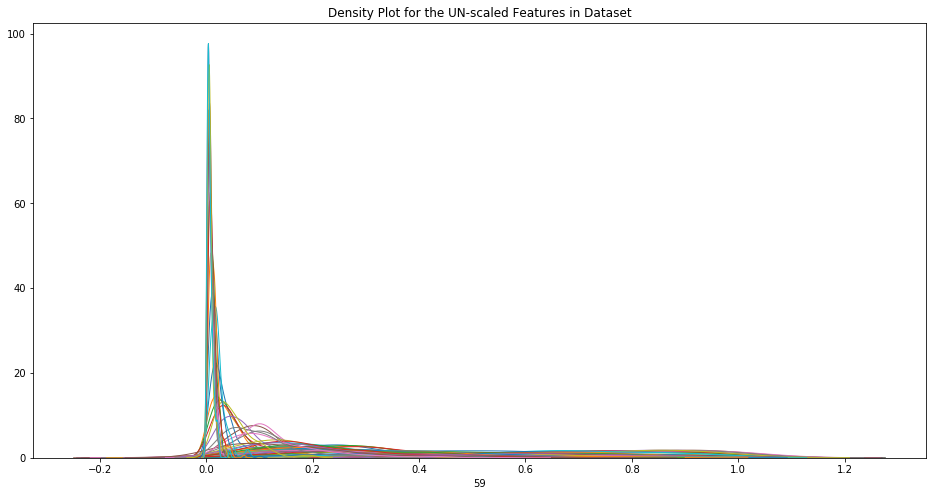

In [122]:

plt.figure(figsize=(16,8))
plt.title('Density Plot for the UN-scaled Features in Dataset')
for i in x_unscaled.columns:
    # Draw the density plot
    sns.distplot(x_unscaled[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1})
    

## Scale the features
The SMV performs faster if features are scaled

In [123]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_unscaled)
x = pd.DataFrame(scaler.transform(x_unscaled), index=x_unscaled.index, columns=x_unscaled.columns)
print("x shape: ",x.shape)
x.describe()

x shape:  (208, 60)


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
count,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,...,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,208.000000
mean,1.259676e-16,-1.708035e-17,-2.860959e-16,6.565261e-17,4.270089e-18,3.416071e-17,2.540703e-16,2.135044e-16,1.964241e-16,2.562053e-17,...,1.024821e-16,-1.665335e-16,1.024821e-16,-2.348549e-16,3.736327e-17,-1.110223e-16,1.878839e-16,-1.195625e-16,-1.216975e-16,0.000000
std,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,...,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413
min,-1.183116e+00,-1.156214e+00,-1.118120e+00,-9.949667e-01,-1.199456e+00,-1.601829e+00,-1.807042e+00,-1.484890e+00,-1.370317e+00,-1.327406e+00,...,-1.185540e+00,-1.354626e+00,-1.334996e+00,-1.348450e+00,-1.320799e+00,-1.442634e+00,-1.251480e+00,-1.262764e+00,-1.143603e+00,-1.024552
25%,-7.056588e-01,-7.471336e-01,-6.991299e-01,-6.428621e-01,-6.778783e-01,-7.133108e-01,-5.869469e-01,-6.372200e-01,-6.614144e-01,-7.114643e-01,...,-6.996136e-01,-6.988984e-01,-7.836352e-01,-7.532933e-01,-7.756190e-01,-6.946015e-01,-7.420027e-01,-7.472279e-01,-6.223295e-01,-0.653959
50%,-3.043475e-01,-2.445492e-01,-2.737717e-01,-2.928166e-01,-1.904398e-01,-1.885136e-01,-2.874616e-01,-2.591733e-01,-2.403004e-01,-2.032221e-01,...,-2.022988e-01,-2.128888e-01,-2.184901e-01,-2.507163e-01,-2.526913e-01,-2.137235e-01,-3.555025e-01,-2.490204e-01,-2.850347e-01,-0.291423
75%,4.355059e-01,4.713415e-01,3.935567e-01,3.022607e-01,3.311383e-01,3.826146e-01,4.349952e-01,4.352820e-01,4.334413e-01,3.691357e-01,...,3.405716e-01,3.425507e-01,5.120633e-01,4.370208e-01,4.742152e-01,5.298563e-01,5.404752e-01,5.741050e-01,1.902443e-01,0.252381
max,4.398198e+00,5.660819e+00,6.635115e+00,7.665570e+00,6.261955e+00,3.514510e+00,3.431078e+00,3.839464e+00,4.119611e+00,3.617419e+00,...,6.323535e+00,5.855802e+00,3.834014e+00,3.174743e+00,4.168087e+00,4.292281e+00,4.247363e+00,5.218265e+00,4.406429e+00,5.952253


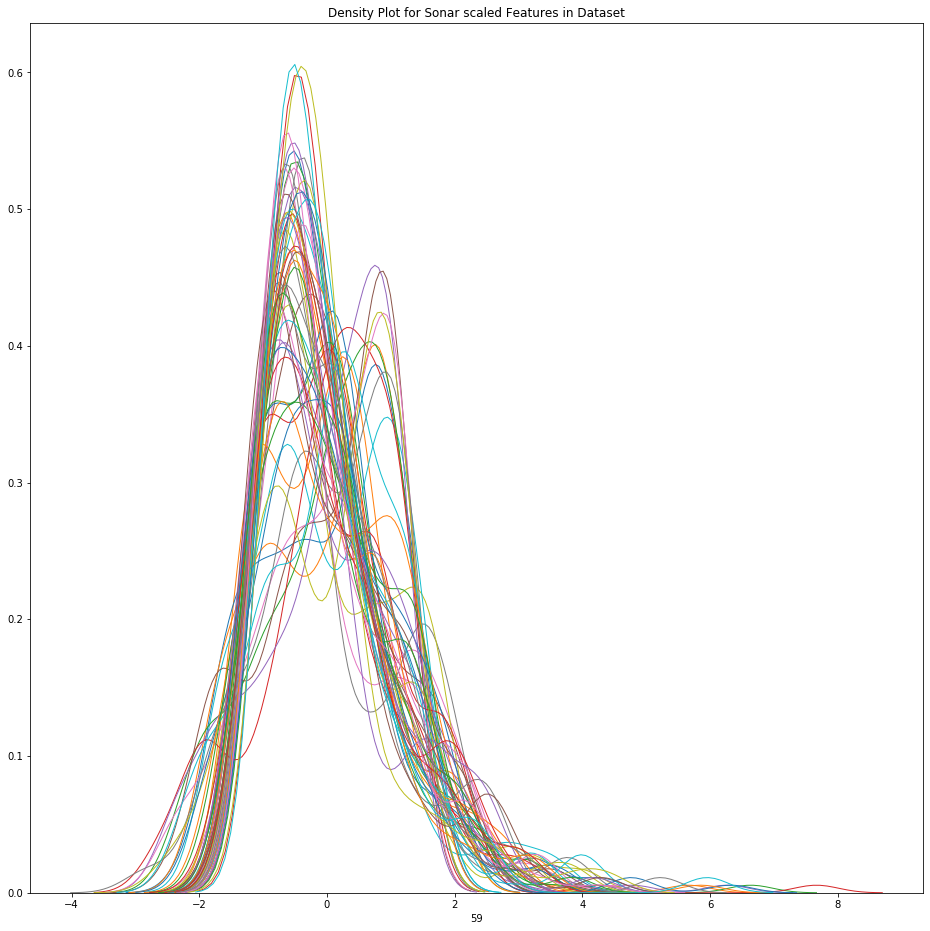

In [124]:
plt.figure(figsize=(16,16))
plt.title('Density Plot for Sonar scaled Features in Dataset')
for i in x.columns:
    # Draw the density plot
    sns.distplot(x[i], hist = False, kde = True,
                 kde_kws = {'linewidth': 1})
    

## Fitting a Support Vector Machine
Use Scikit-Learn's support vector classifier to train an SVM model on this data. Let'set the  𝐶  parameter to a very large number.

In [125]:
from sklearn.svm import SVC # "Support vector classifier"
from timeit import default_timer as timer

model = SVC(kernel='linear', C=1E4)
start = timer()
model.fit(x, y)
end = timer()
print(end - start)

model1 = SVC(kernel='linear', C=1E4)
start = timer()
model1.fit(x_unscaled, y)
end = timer()
print(end - start)




0.006013008000081754
0.037372960000539024


In [126]:
print(len(model.support_vectors_))
#print(model.support_vectors_)

print(len(model1.support_vectors_))
#print(model1.support_vectors_)

52
60


The SVM fit performed on unscalsed features is 6 times slower and has 8 more support vectors 

From the previous experiences with the Sonar Dataset (https://github.com/borodark/ie7860/blob/master/Feature%20Selection%20and%20Visualization%20Sonar%20Data%20Set.ipynb) we know that several features are more important. Here is 24 best Features by F score: [0  1  3  7  8  9 10 11 12 33 35 36 43 44 45 46 47 48 49 50 51 53 57 59]

Let's fit SVM on 2 and visualize the hyperplane

## Fit SVM on 2 features and visualize the hyperplane

In [127]:
# define the function for plotting the decision boundary
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # Plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=50, linewidth=1, color='#000000', facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [128]:
# fit SVM on features [10,50] - 
X = x[[10,50]]
X1 = X.to_numpy()


In [129]:
model3 = SVC(kernel='linear', C=1E4)
start = timer()
model3.fit(X, y)
end = timer()
print(end - start)


0.20406295799966756


There are  99  support vectors 


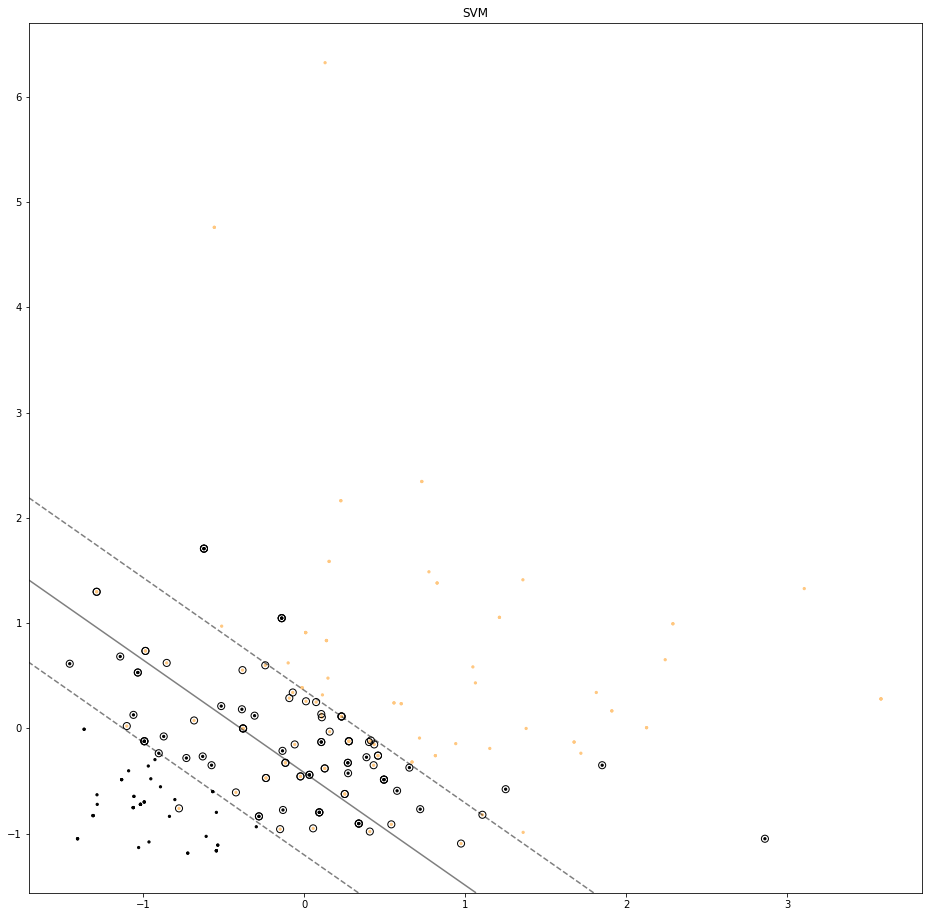

In [130]:
print("There are ", len(model3.support_vectors_), " support vectors ")
plt.figure(figsize=(16,16))
plt.title('SVM')
plt.scatter(X1[:, 0], X1[:, 1], c=y, s=5, cmap='copper')
plot_svc_decision_function(model3);

## Use 'poly' kernel with SVM

In [131]:
poly = SVC(kernel='poly', C=1E4, gamma='scale')
poly.fit(X, y)


SVC(C=10000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

There are  97  support vectors for poly kernel


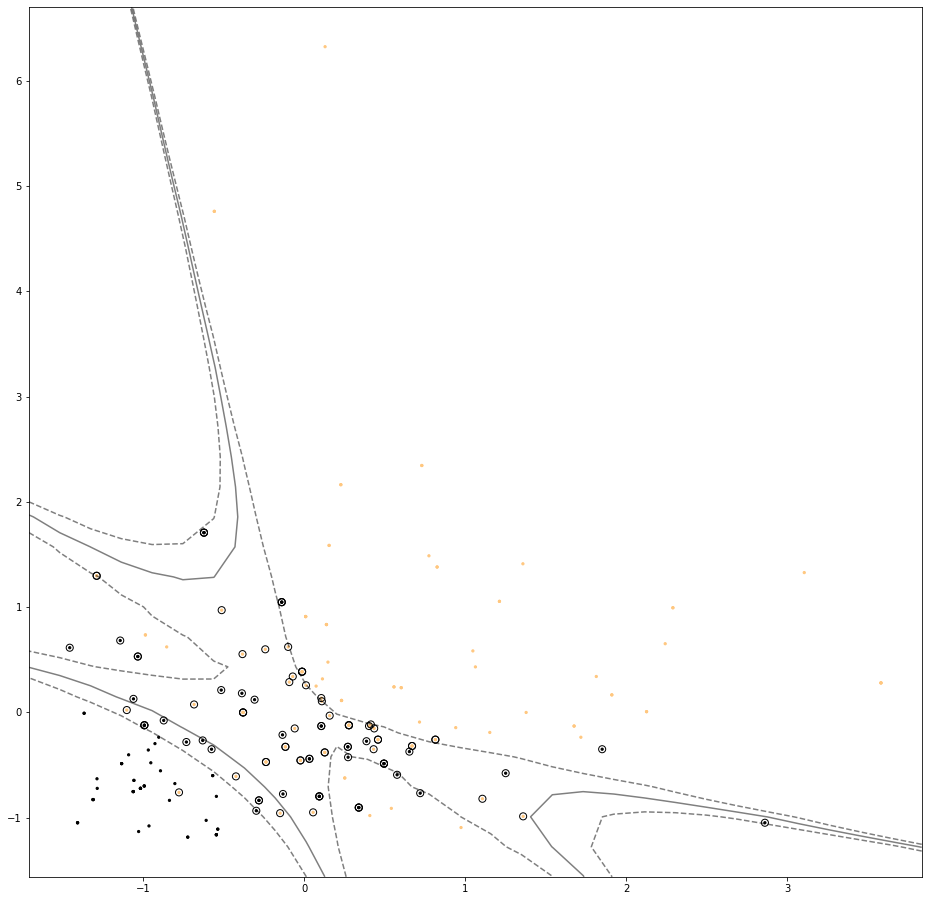

In [132]:
print("There are ", len(poly.support_vectors_), " support vectors for poly kernel")
plt.figure(figsize=(16,16))
plt.scatter(X1[:, 0], X1[:, 1], c=y, s=5, cmap='copper')
plot_svc_decision_function(poly);

## Comparing to other Classifiers

### Scaled features dataset

In [133]:
# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB


In [134]:
# Create a validation dataset
# Split-out validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.20, random_state=1)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
23,-0.771515,-0.735446,-0.809927,-0.957903,-0.943409,0.029719,-0.341615,-1.032878,-0.674422,-0.972969,...,-0.487021,-0.500894,-1.321212,-0.369748,-0.460379,-1.050807,-0.794707,-0.673580,-0.101056,-0.460607
97,0.776106,-0.358507,0.351530,1.500652,2.017258,1.501922,1.617757,-0.647787,-0.418339,-0.040772,...,0.735386,-0.603754,0.236383,0.648632,-0.475214,0.605550,2.104044,1.111303,3.915819,5.952253
94,-1.141956,-0.270847,-0.720780,-0.644921,-0.520457,0.317231,1.174683,0.400647,-0.319158,-0.471571,...,-0.479428,0.095689,-0.480387,-1.004582,0.281362,0.000000,0.470202,-1.037488,-0.744982,-0.895650
47,0.290416,-0.352663,-0.565409,-0.651098,-1.004102,-0.533182,-0.640280,-0.339009,-0.624018,-0.923982,...,-0.798317,-1.354626,-0.921475,-1.163290,-1.320799,-0.213724,0.382362,-0.378988,0.128918,-0.154465
10,-1.084332,-0.989660,-0.769174,-0.422539,-0.755641,-1.310852,-1.370532,-1.230119,-1.168702,-1.176122,...,-0.828688,-0.799186,0.112327,-0.792970,-0.579058,0.142482,-0.566321,-1.262764,-0.361693,-0.541170


In [135]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
24,-0.038865,0.708024,-0.162975,-0.758171,-0.440797,-0.389426,-0.390846,-1.179635,-0.832949,-0.882199,...,-0.008688,-1.076906,-0.824987,-0.382973,-0.252691,-0.178103,0.540475,1.457882,0.282234,-0.943988
54,-0.701543,-0.939986,-0.677480,-0.824062,-0.516663,-0.645763,-1.020995,-1.395662,-0.700437,-0.837534,...,-0.266836,-0.984333,-1.155804,-1.202968,-1.083442,-0.658981,1.120226,1.111303,-0.744982,-0.090014
114,-0.775631,-0.525061,-0.471168,-0.323703,0.964619,1.768651,0.423098,-0.458763,-0.333791,-0.205743,...,0.317794,1.329999,0.553415,1.918301,0.029170,-0.783653,-0.425775,1.197947,0.404886,-0.718410
205,0.903702,0.103169,-0.697856,-0.513139,-0.677878,0.225435,0.042382,-0.166423,-0.408583,0.320149,...,-0.122577,0.208834,-1.142020,-0.806196,-0.490049,0.071241,1.155362,1.076645,0.006265,-0.621734
115,0.459173,0.100247,-0.017793,0.623479,-0.548906,0.301643,1.264939,0.230409,-0.766286,-0.078953,...,0.386127,-0.974047,0.332871,0.013798,-0.623562,1.424824,1.172930,0.019578,2.597303,2.069089


In [136]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.850368 (0.069524)
LDA: 0.758824 (0.079809)
KNN: 0.880147 (0.108518)
CART: 0.842647 (0.087987)
NB: 0.747426 (0.057335)
SVM: 0.904779 (0.053212)


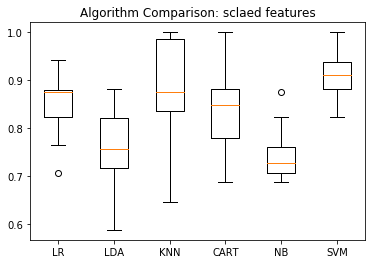

In [137]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison: sclaed features')
plt.show()

SVM has the highest median out of all!

In [138]:
# Make predictions on validation dataset
model = SVC(gamma='auto',C=1E10)
start = timer()
model.fit(X_train, Y_train)
end = timer()
print(end - start)
predictions = model.predict(X_test)

0.004186975999800779


There are  91  support vectors 
0.9761904761904762
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        21
           1       0.95      1.00      0.98        21

    accuracy                           0.98        42
   macro avg       0.98      0.98      0.98        42
weighted avg       0.98      0.98      0.98        42

Confusion Matrix:


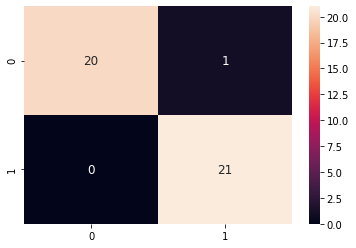

In [139]:
# Evaluate predictions
print("There are ", len(model.support_vectors_), " support vectors ")
print(accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))
cm = confusion_matrix(Y_test,predictions)
print('Confusion Matrix:')
sns.heatmap(cm,annot=True,fmt="d", annot_kws={"size": 12}) # font size

### Unscaled features

In [140]:
# Create a validation dataset
# Split-out validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(x_unscaled, y, test_size=0.20, random_state=1)
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.785294 (0.114080)
LDA: 0.758824 (0.079809)
KNN: 0.819485 (0.088426)
CART: 0.831250 (0.110838)
NB: 0.747426 (0.057335)
SVM: 0.631985 (0.066043)


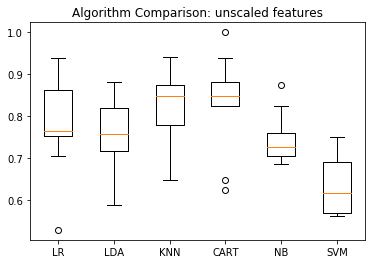

In [141]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison: unscaled features')
plt.show()

### Conclusion
* The SVM classifier is able to reach %98 accuracy and performs faster then MLP - fit takes only `0.003992759000539081` seconds compare to several minutes for Neural Networks 
* The SVM classifier is sensitive to feature sclaing: slower speed and lower precision